## Seminar 4

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Problem**: Predict Wi-Fi performance (throughput and latency) based on physical and link-layer features collected from residential networks.

**ML Technique**: We will use Neural Networks to model non-linear relationships between input features (e.g., RSSI, link speeds) and output performance metrics. Implementation is done using Keras and TensorFlow.

**Preprocessing:** We validated that the dataset contains no missing values. We analyzed the distributions and normalized numerical features to prepare for neural network training. We also performed correlation analysis to understand how each feature impacts throughput and delay.

**Evaluation Metrics**: Performance will be evaluated using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) on the test set.

**Analysis of Results**: The correlation analysis shows that RSSI, Tx/Rx link speeds, and AP connectivity are the most relevant features, strongly influencing throughput and latency. These findings support the use of non-linear models like NNs to capture interactions among features.

In [4]:
traindata_path = '/content/drive/Shareddrives/ML4Net/Seminar4/dataset_Seminar4/train_data.csv'
train_data = pd.read_csv(traindata_path)
print(train_data.head())


   LocationNumber   RSSI  TxLinkSpeed  RxLinkSpeed  MainAPConnect  \
0               2 -72.32       163.11       118.36              1   
1              32 -73.18       238.45       212.83              1   
2              20 -40.67       865.44       863.39              1   
3              10 -60.66       473.89       396.92              1   
4              29 -67.96       479.74       355.99              1   

   TxThroughput  AvgPingLatency  
0         13.51           51.79  
1          3.35           68.80  
2         17.62           50.79  
3         14.30           64.15  
4          4.81           73.81  


In [5]:
print(train_data.isnull().sum())


LocationNumber    0
RSSI              0
TxLinkSpeed       0
RxLinkSpeed       0
MainAPConnect     0
TxThroughput      0
AvgPingLatency    0
dtype: int64


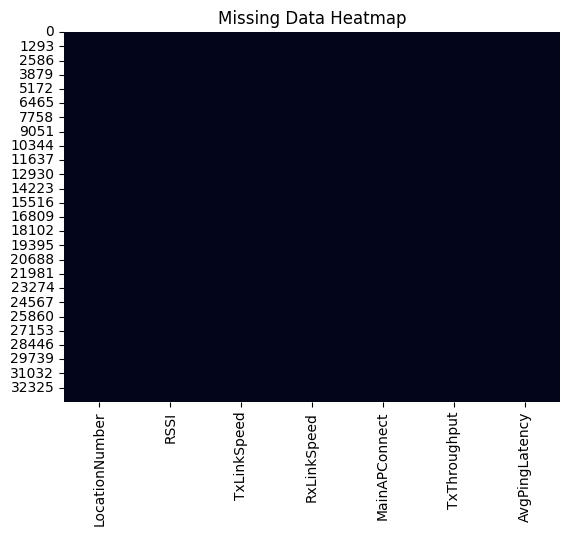

In [6]:
sns.heatmap(train_data.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()


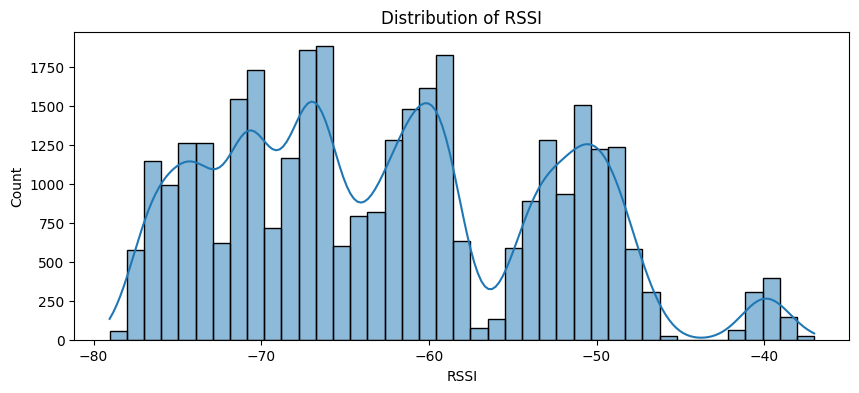

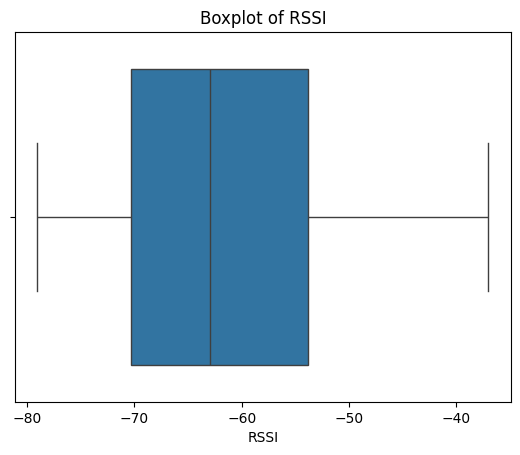

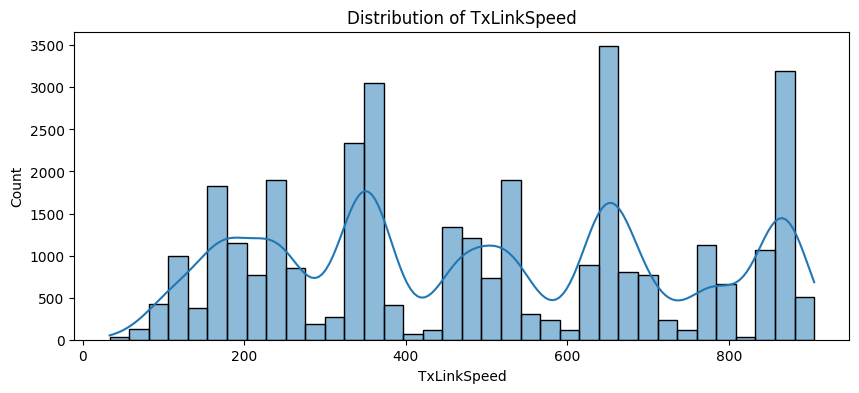

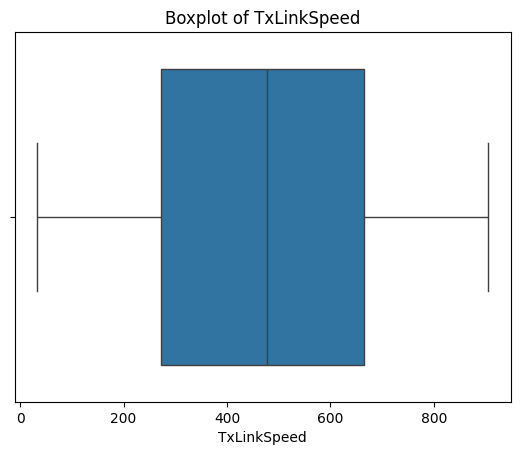

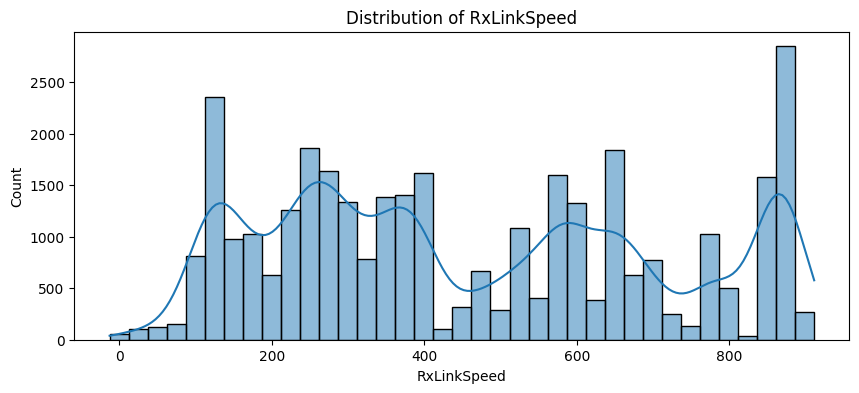

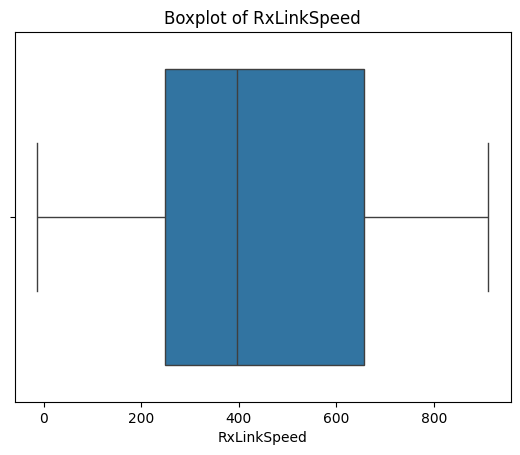

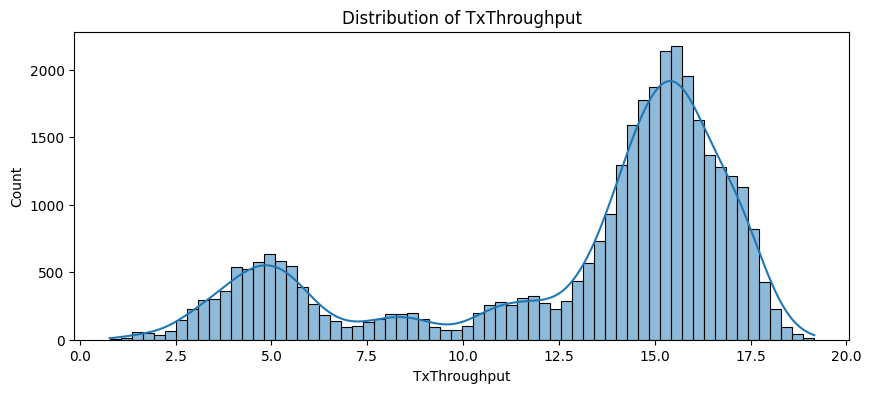

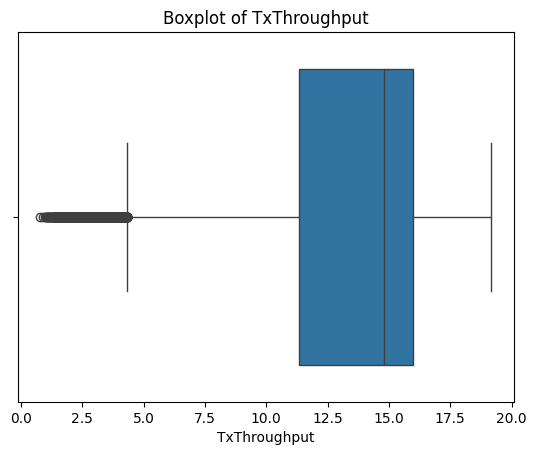

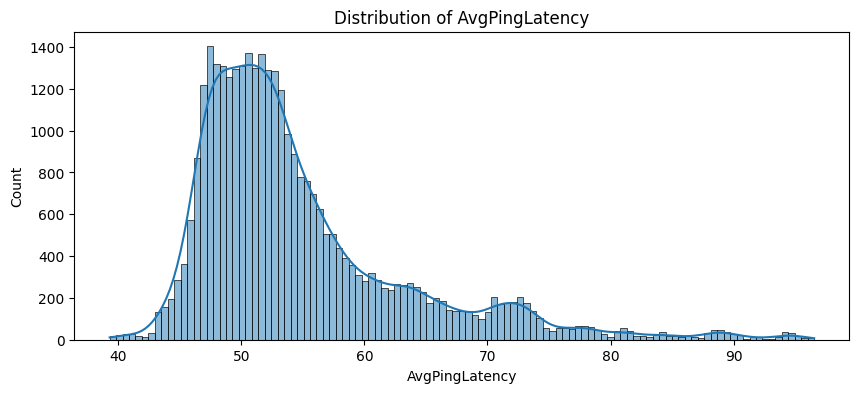

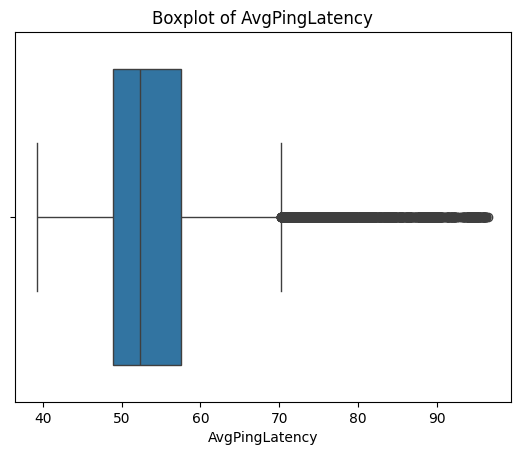

In [7]:
numeric_features = ['RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'TxThroughput', 'AvgPingLatency']

for feature in numeric_features:
    plt.figure(figsize=(10,4))
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

    sns.boxplot(x=train_data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()


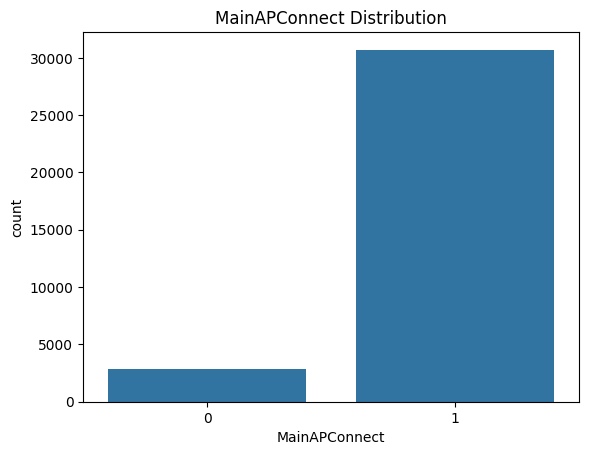

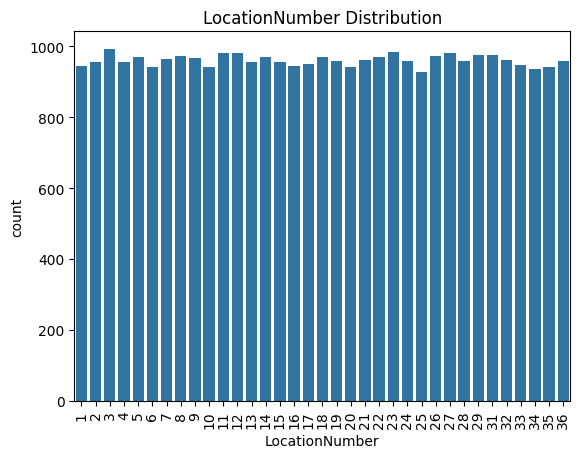

In [8]:
sns.countplot(x='MainAPConnect', data=train_data)
plt.title("MainAPConnect Distribution")
plt.show()

sns.countplot(x='LocationNumber', data=train_data)
plt.title("LocationNumber Distribution")
plt.xticks(rotation=90)
plt.show()


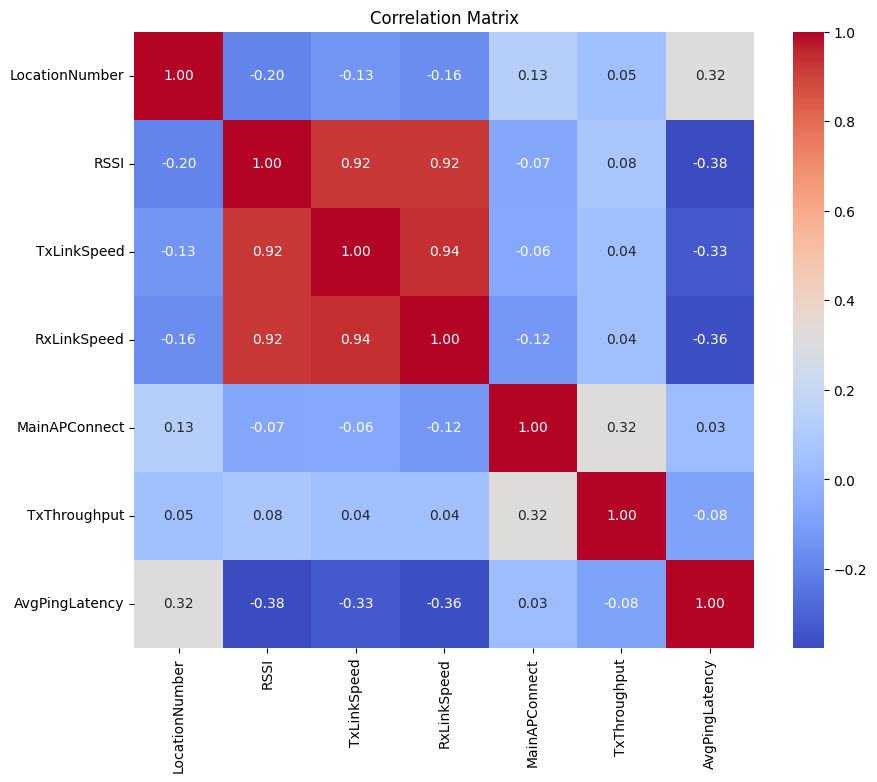

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## Feature Selection

We will compute Pearson correlations between our five inputs and the two targets  in order to decide which features to keep, drop, or transform.

In [10]:
correlation_matrix = train_data.corr()

perf_metrics = ['TxThroughput', 'AvgPingLatency']
corr_with_perf = correlation_matrix[perf_metrics].drop(perf_metrics)

print(corr_with_perf)


                TxThroughput  AvgPingLatency
LocationNumber      0.046687        0.322541
RSSI                0.076853       -0.375971
TxLinkSpeed         0.044451       -0.331170
RxLinkSpeed         0.044280       -0.361945
MainAPConnect       0.321010        0.028982


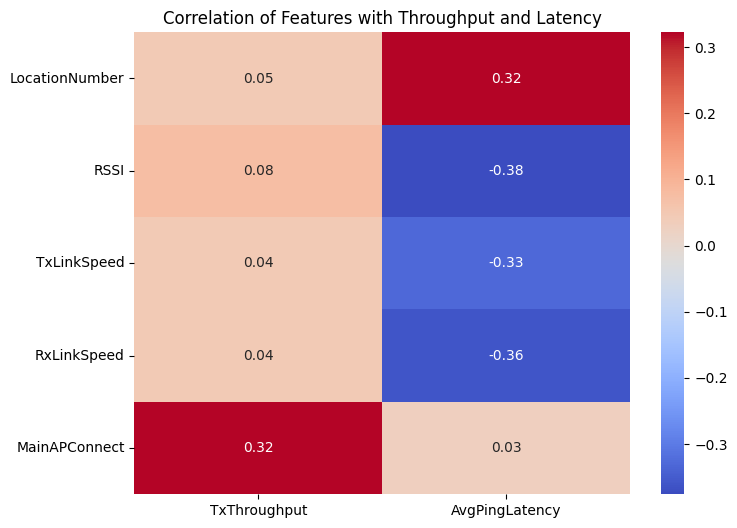

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_with_perf, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with Throughput and Latency")
plt.show()

### Final Inputs

After computing the Pearson correlation, we decided to keep RSSI, TxLinkSpeed and MainAPConnect, to drop RxLinkSpeed (redundant), and to one-hot encode LocationNumber.

In [12]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

loc_ohe = OneHotEncoder(sparse_output=False, drop='first')
loc_feats = loc_ohe.fit_transform(train_data[['LocationNumber']])

loc_feat_names = loc_ohe.get_feature_names_out(['LocationNumber']).tolist()

selected_numeric = train_data[['RSSI','TxLinkSpeed','MainAPConnect']].to_numpy()
X_train = np.hstack([loc_feats, selected_numeric])

print("Final feature matrix shape:", X_train.shape)
print("Feature names:", loc_feat_names + ['RSSI','TxLinkSpeed','MainAPConnect'])

Final feature matrix shape: (33600, 37)
Feature names: ['LocationNumber_2', 'LocationNumber_3', 'LocationNumber_4', 'LocationNumber_5', 'LocationNumber_6', 'LocationNumber_7', 'LocationNumber_8', 'LocationNumber_9', 'LocationNumber_10', 'LocationNumber_11', 'LocationNumber_12', 'LocationNumber_13', 'LocationNumber_14', 'LocationNumber_15', 'LocationNumber_16', 'LocationNumber_17', 'LocationNumber_18', 'LocationNumber_19', 'LocationNumber_20', 'LocationNumber_21', 'LocationNumber_22', 'LocationNumber_23', 'LocationNumber_24', 'LocationNumber_25', 'LocationNumber_26', 'LocationNumber_27', 'LocationNumber_28', 'LocationNumber_29', 'LocationNumber_31', 'LocationNumber_32', 'LocationNumber_33', 'LocationNumber_34', 'LocationNumber_35', 'LocationNumber_36', 'RSSI', 'TxLinkSpeed', 'MainAPConnect']


## Preprocessing

1. One-hot encode LocationNumber
2. Stack with numeric features  
3. Standard-scale train → test


In [13]:
testdata_path = '/content/drive/Shareddrives/ML4Net/Seminar4/dataset_Seminar4/test_data.csv'
test_data = pd.read_csv(testdata_path)
print("Test rows:", test_data.shape[0])

loc_feats_test = loc_ohe.transform(test_data[['LocationNumber']])

numeric_test = test_data[['RSSI','TxLinkSpeed','MainAPConnect']].to_numpy()

X_test = np.hstack([loc_feats_test, numeric_test])
print("Test feature matrix shape:", X_test.shape)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)

Test rows: 8400
Test feature matrix shape: (8400, 37)
Scaled shapes: (33600, 37) (8400, 37)


## FNN Architecture

Our model will have the following archiceture:

- 2 hidden layers (64→32 ReLU)  
- Shared trunk → two linear heads  
- MSE loss + MAE metrics

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_dim = X_train_scaled.shape[1]

inputs = Input(shape=(input_dim,), name='features')
x = Dense(64, activation='relu', name='hidden_1')(inputs)
x = Dense(32, activation='relu', name='hidden_2')(x)

throughput_out = Dense(1, activation='linear', name='throughput')(x)
latency_out    = Dense(1, activation='linear', name='latency')(x)

model = Model(inputs=inputs, outputs=[throughput_out, latency_out], name='FNN_wifi')
model.compile(
    optimizer='adam',
    loss     ={'throughput':'mse', 'latency':'mse'},
    metrics  ={'throughput':'mae', 'latency':'mae'}
)

model.summary()

Model: "FNN_wifi"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_1 (Dense)    │ (None, 64)        │      2,432 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_2 (Dense)    │ (None, 32)        │      2,080 │ hidden_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ throughput (Dense)  │ (None, 1)         │         33 │ hidden_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latency (Dense)     │ (None, 1)         │         33 │ hidden_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,578 (17.88 KB)

 Trainable params: 4,578 (17.88 KB)

 Non-trainable params: 0 (0.00 B)

## Training

We will train our model using the following parameters:

- Optimizer: Adam  
- Batch: 64, Epochs: 50  
- Callbacks: EarlyStopping (patience=5), ModelCheckpoint


In [15]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mc = ModelCheckpoint(
    '/content/best_fnn.h5', monitor='val_loss',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train_scaled,
    {'throughput': train_data['TxThroughput'], 'latency': train_data['AvgPingLatency']},
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[es, mc],
    verbose=1
)

Epoch 1/50
416/420 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - latency_loss: 1458.0608 - latency_mae: 31.2427 - loss: 1556.0010 - throughput_loss: 97.9401 - throughput_mae: 8.2259 
Epoch 1: val_loss improved from inf to 50.81812, saving model to /content/best_fnn.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - latency_loss: 1447.6790 - latency_mae: 31.0540 - loss: 1545.0288 - throughput_loss: 97.3497 - throughput_mae: 8.1917 - val_latency_loss: 33.2165 - val_latency_mae: 4.0739 - val_loss: 50.8181 - val_throughput_loss: 17.6016 - val_throughput_mae: 3.3109
Epoch 2/50
404/420 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - latency_loss: 31.9269 - latency_mae: 4.0155 - loss: 48.7470 - throughput_loss: 16.8201 - throughput_mae: 3.2742
Epoch 2: val_loss improved from 50.81812 to 49.51091, saving model to /content/best_fnn.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - latency_loss: 31.9322 - latency_mae: 4.0166 - loss: 48.7354 - throughput_loss: 16.8032 - throughput_mae: 3.2721 - val_latency_loss: 33.3399 - val_latency_mae: 4.0160 - val_loss: 49.5109 - val_throughput_loss: 16.1710 - val_throughput_mae: 3.2396
Epoch 3/50
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - latency_loss: 32.2237 - latency_mae: 4.0491 - loss: 48.1293 - throughput_loss: 15.9056 - throughput_mae: 3.1413
Epoch 3: val_loss improved from 49.51091 to 48.64484, saving model to /content/best_fnn.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - latency_loss: 32.2213 - latency_mae: 4.0490 - loss: 48.1267 - throughput_loss: 15.9053 - throughput_mae: 3.1413 - val_latency_loss: 32.5703 - val_latency_mae: 4.0420 - val_loss: 48.6448 - val_throughput_loss: 16.0745 - val_throughput_mae: 3.2625
Epoch 4/50
413/420 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - latency_loss: 32.0173 - latency_mae: 4.0147 - loss: 47.7762 - throughput_loss: 15.7590 - throughput_mae: 3.1248
Epoch 4: val_loss did not improve from 48.64484
420/420 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - latency_loss: 32.0112 - latency_mae: 4.0144 - loss: 47.7706 - throughput_loss: 15.7594 - throughput_mae: 3.1246 - val_latency_loss: 33.0212 - val_latency_mae: 3.9924 - val_loss: 49.0434 - val_throughput_loss: 16.0222 - val_throughput_mae: 3.1802
Epoch 5/50
407/420 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - latency_loss: 31.2803 - latency_mae: 3.9764 - loss: 46.8515 - throughput_loss: 15.5713 - throughput_mae: 3.0940
Epoch 5: val_loss did not improve from 48.

## Training History

Below are the training and validation MSE curves for throughput loss and latency loss




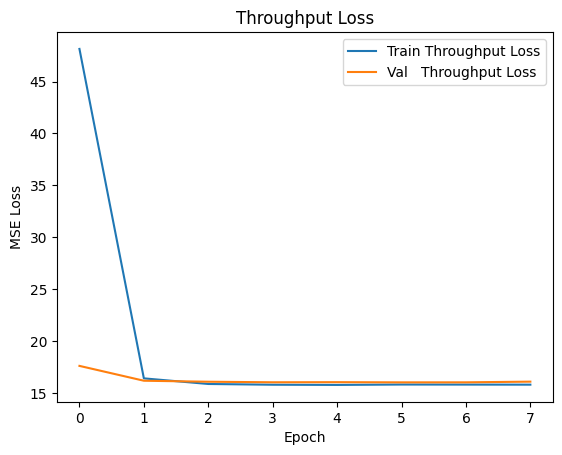

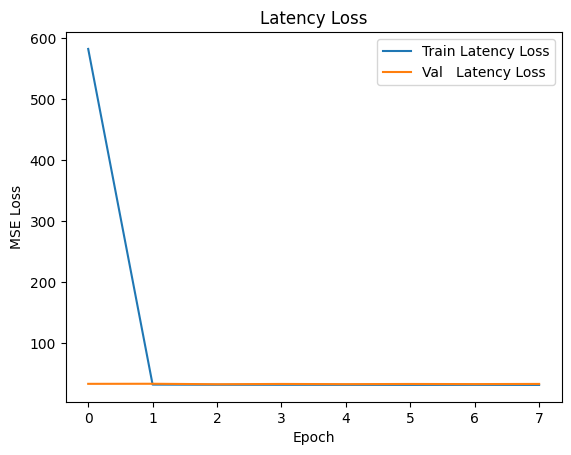

In [16]:
plt.figure()
plt.plot(history.history['throughput_loss'],    label='Train Throughput Loss')
plt.plot(history.history['val_throughput_loss'],label='Val   Throughput Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Throughput Loss'); plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['latency_loss'],    label='Train Latency Loss')
plt.plot(history.history['val_latency_loss'],label='Val   Latency Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Latency Loss'); plt.legend()
plt.show()

## Model Evaluation on Test Set

Now we evaluate our trained model with the test data and we compute the MSE and MAE for both targets to quantify predictive accuracy. The results represent the performance of our model on unseen data.


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true_th = test_data['TxThroughput'].to_numpy()
y_true_lat = test_data['AvgPingLatency'].to_numpy()

y_pred_th, y_pred_lat = model.predict(X_test_scaled, verbose=0)

mse_th = mean_squared_error(y_true_th, y_pred_th)
mae_th = mean_absolute_error(y_true_th, y_pred_th)
mse_lat = mean_squared_error(y_true_lat, y_pred_lat)
mae_lat = mean_absolute_error(y_true_lat, y_pred_lat)

print(f"Throughput → MSE: {mse_th:.2f}, MAE: {mae_th:.2f}")
print(f"Latency    → MSE: {mse_lat:.2f}, MAE: {mae_lat:.2f}")

Throughput → MSE: 15.85, MAE: 3.21
Latency    → MSE: 31.82, MAE: 4.03


## Conclusion

Our FNN achieves a Throughput MAE of 3.21 Mbps (MSE ~15.9), meaning on average we’re within 3 Mbps of the true throughput. For Latenc*, we get an MAE of 4.03 ms (MSE ~31.8), so predictions are on average 4 ms off. These errors are reasonably small given the range of our targets, showing the network captures the main signal–performance relationships.  
